In [1]:
import numpy as np
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from utils.data_formats import timeseries_to_channels
from simulators import Simulator
from spectralcomponents import PowerLaw, GaussianEmissionLine, Spectrum
from sbi.inference import SNRE_B, SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.neural_nets.embedding_nets import FCEmbedding, CNNEmbedding, PermutationInvariantEmbedding
from sbi_tools import BoxUniform
from sbi.inference import SNPE
from sbi.utils import posterior_nn



c1 = PowerLaw()
spectrum = Spectrum(c1)

prior = BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([1, 2]))
def simulate_simple(params):
    simulator =  Simulator(spectrum, 1000, pileup='channels')
    data = simulator(params)
    return np.histogram(data[data>0], bins=50)[0]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-14 10:19:08.792418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
true_params = (0.3, 1)
x0 = simulate_simple(true_params)
x0

array([15, 36, 42, 39, 37, 44, 26, 32, 28, 25, 31, 25, 28, 20, 25, 15, 23,
       21, 17, 23, 13, 16,  8, 19, 10, 15, 11, 13,  7,  7,  8,  9,  5,  6,
        8,  5,  3,  4,  9,  7,  7,  6,  1,  2,  4,  2,  5,  2,  1,  1])

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:38<00:00, 25.74it/s]


 Neural network successfully converged after 71 epochs.

Drawing 1000 posterior samples: 1157it [00:00, 107950.57it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:47<00:00, 21.20it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples: 10447it [00:00, 71837.79it/s]                          


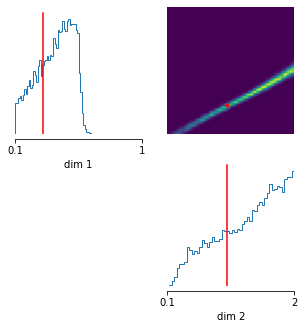

In [18]:

simulator, prior = prepare_for_sbi(simulate_simple, prior)
embedding_net = FCEmbedding(input_dim=50, output_dim=10)
neural_posterior = posterior_nn(
    model="maf", 
    embedding_net=embedding_net, 
    hidden_features=10, 
    num_transforms=2
)

rounds = 2
num_sims = 1000
x_0 = simulate_simple(true_params)

inference = SNPE(
    prior=prior, 
    density_estimator=neural_posterior
)

proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:53<00:00, 18.57it/s]


 Neural network successfully converged after 162 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 22.76it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 73 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.38it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.80it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:41<00:00, 23.97it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.71it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:40<00:00, 24.55it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.33it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 225723.51it/s]


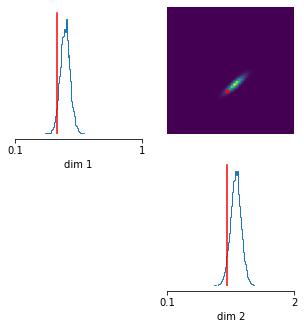

In [19]:
true_params = (0.4, 1)
x0 = simulate_simple(true_params)

simulator, prior = prepare_for_sbi(simulate_simple, prior)
embedding_net = FCEmbedding(input_dim=50, output_dim=10)
neural_posterior = posterior_nn(
model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2)

rounds = 10
num_sims = 1000
x_0 = simulate_simple(true_params)

inference = SNPE(prior=prior, density_estimator=neural_posterior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.58it/s]


 Neural network successfully converged after 89 epochs.

Drawing 1000 posterior samples: 1080it [00:00, 122325.84it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:37<00:00, 26.51it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.

Drawing 1000 posterior samples: 1134it [00:00, 116645.59it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:37<00:00, 26.99it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 1000 posterior samples: 1250it [00:00, 120379.31it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:37<00:00, 26.69it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 1000 posterior samples: 1208it [00:00, 104092.85it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 1000 posterior samples: 1121it [00:00, 112370.70it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.80it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 1000 posterior samples: 1098it [00:00, 120068.46it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [01:12<00:00, 13.85it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.

Drawing 1000 posterior samples: 1067it [00:00, 22543.43it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:57<00:00, 17.30it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 1000 posterior samples: 1086it [00:00, 138361.96it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:41<00:00, 23.88it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 1000 posterior samples: 1106it [00:00, 127201.19it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.50it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples: 10957it [00:00, 130256.19it/s]           


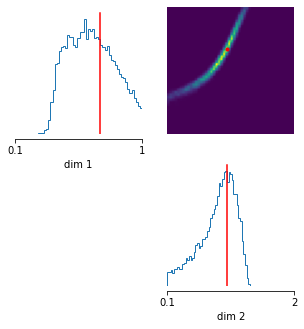

In [20]:
true_params = (0.7, 1)
x0 = simulate_simple(true_params)

simulator, prior = prepare_for_sbi(simulate_simple, prior)
embedding_net = FCEmbedding(input_dim=50, output_dim=10)
neural_posterior = posterior_nn(
model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2)

rounds = 10
num_sims = 1000
x_0 = simulate_simple(true_params)

inference = SNPE(prior=prior, density_estimator=neural_posterior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.67it/s]


 Neural network successfully converged after 118 epochs.

Drawing 1000 posterior samples: 1096it [00:00, 107250.18it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 23.00it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 87 epochs.

Drawing 1000 posterior samples: 1158it [00:00, 121270.48it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:41<00:00, 24.28it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Drawing 1000 posterior samples: 1265it [00:00, 108957.50it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.55it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 1000 posterior samples: 1267it [00:00, 104062.96it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.53it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 1000 posterior samples: 1261it [00:00, 38347.89it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 23.26it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 1000 posterior samples: 1225it [00:00, 31880.11it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.62it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 1000 posterior samples: 1292it [00:00, 45419.08it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 22.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 1000 posterior samples: 1383it [00:00, 35046.51it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:40<00:00, 24.58it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 103 epochs.

Drawing 1000 posterior samples: 1092it [00:00, 11164.72it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.72it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples: 10032it [00:00, 15691.87it/s]                          


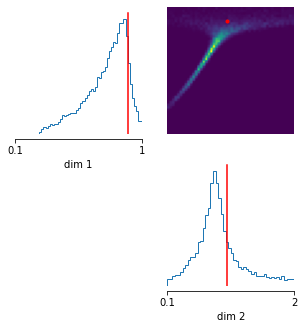

In [21]:
true_params = (0.9, 1)
x0 = simulate_simple(true_params)

simulator, prior = prepare_for_sbi(simulate_simple, prior)
embedding_net = FCEmbedding(input_dim=50, output_dim=10)
neural_posterior = posterior_nn(
model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2)

rounds = 10
num_sims = 1000
x_0 = simulate_simple(true_params)

inference = SNPE(prior=prior, density_estimator=neural_posterior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

### Now we try basic 10-bin histogram summary statistic with no embedding net


In [41]:
def simulate_simple(params):
    simulator =  Simulator(spectrum, 1000, pileup='channels')
    data = simulator(params)
    return np.histogram(data[data>0], bins=10)[0]

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:45<00:00, 21.86it/s]


 Neural network successfully converged after 202 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:50<00:00, 19.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 69 epochs.

Drawing 1000 posterior samples: 1078it [00:00, 15549.20it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:39<00:00, 25.57it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples: 1087it [00:00, 22111.79it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.56it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 1000 posterior samples: 1078it [00:00, 17861.29it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.55it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Drawing 1000 posterior samples: 1078it [00:00, 18475.00it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:39<00:00, 25.08it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 1000 posterior samples: 1056it [00:00, 21573.47it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:38<00:00, 25.82it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 1000 posterior samples: 1074it [00:00, 22189.57it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:40<00:00, 24.76it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 1000 posterior samples: 1063it [00:00, 16962.12it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:40<00:00, 24.57it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 1000 posterior samples: 1065it [00:00, 9120.19it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples: 10122it [00:00, 13582.11it/s]                          


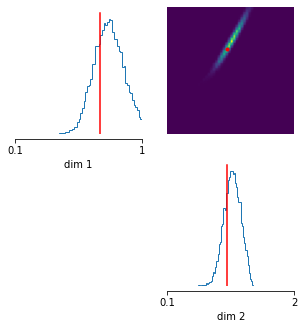

In [43]:

true_params = (0.7, 1)
simulator, prior = prepare_for_sbi(simulate_simple, prior)
x_0 = simulate_simple(true_params)


rounds = 10
num_sims = 1000

inference = SNPE(prior=prior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 22.78it/s]


 Neural network successfully converged after 112 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.63it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.32it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:47<00:00, 21.19it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:48<00:00, 20.81it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.36it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:45<00:00, 22.22it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.52it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.61it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:48<00:00, 20.77it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 46418.37it/s]


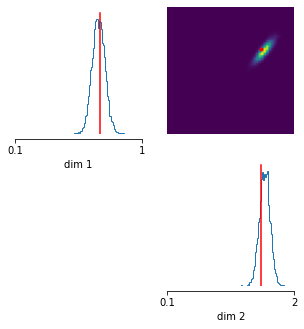

In [44]:

true_params = (0.7, 1.5)
simulator, prior = prepare_for_sbi(simulate_simple, prior)
x_0 = simulate_simple(true_params)


rounds = 10
num_sims = 1000

inference = SNPE(prior=prior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.27it/s]


 Neural network successfully converged after 120 epochs.

Drawing 1000 posterior samples: 1086it [00:00, 12245.72it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 22.77it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.

Drawing 1000 posterior samples: 1066it [00:00, 11831.32it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 22.80it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Drawing 1000 posterior samples: 1069it [00:00, 15585.60it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.77it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Drawing 1000 posterior samples: 1098it [00:00, 17740.84it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 23.05it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 1000 posterior samples: 1089it [00:00, 34468.53it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:41<00:00, 24.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 1000 posterior samples: 1096it [00:00, 16983.00it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:49<00:00, 20.19it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 1000 posterior samples: 1096it [00:00, 11563.39it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 23.13it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.

Drawing 1000 posterior samples: 1090it [00:00, 20384.85it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:40<00:00, 24.99it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Drawing 10000 posterior samples: 10037it [00:00, 51374.64it/s]                          


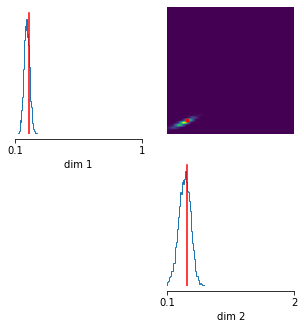

In [45]:

true_params = (0.2, 0.4)
simulator, prior = prepare_for_sbi(simulate_simple, prior)
x_0 = simulate_simple(true_params)


rounds = 10
num_sims = 1000

inference = SNPE(prior=prior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:38<00:00, 26.05it/s]


 Neural network successfully converged after 55 epochs.

Drawing 1000 posterior samples: 1327it [00:00, 4893.63it/s]             
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.47it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 1000 posterior samples: 1031it [00:00, 2080.63it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:48<00:00, 20.51it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 74 epochs.

Drawing 1000 posterior samples: 1017it [00:01, 777.18it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:47<00:00, 21.11it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 82 epochs.

Drawing 1000 posterior samples:   9%|▉         | 93/1000 [00:00<00:02, 383.72it/s]WARNING:root:Only 0.845% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    907 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 1000 posterior samples: 1026it [00:01, 574.50it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.28it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples: 1033it [00:01, 948.58it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 23.22it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 1000 posterior samples: 1018it [00:02, 484.65it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:51<00:00, 19.44it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:46<00:00, 21.47it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 1000 posterior samples: 1039it [00:01, 927.53it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Drawing 1000 posterior samples: 1003it [00:01, 720.89it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Drawing 10000 posterior samples: 10027it [00:15, 645.32it/s]                          


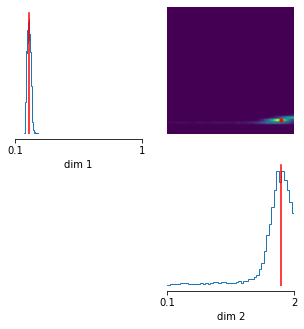

In [53]:

true_params = (0.2, 1.8)
simulator, prior = prepare_for_sbi(simulate_simple, prior)
x_0 = simulate_simple(true_params)


rounds = 10
num_sims = 1000

inference = SNPE(prior=prior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

### Now we try amortized with 100k sims and same 10 bin summary stat


Running 100000 simulations.: 100%|██████████| 100000/100000 [1:08:29<00:00, 24.33it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 67 epochs.

Drawing 10000 posterior samples: 10772it [00:00, 15400.12it/s]                          


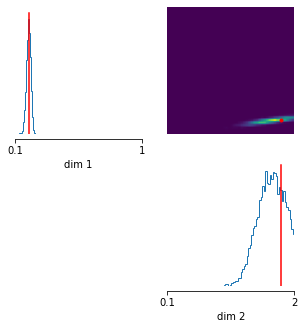

In [57]:
true_params = (0.2, 1.8)
simulator, prior = prepare_for_sbi(simulate_simple, prior)
x_0 = simulate_simple(true_params)

num_sims = 100000

inference = SNPE(prior=prior)
theta, x = simulate_for_sbi(simulator, prior, num_sims)

_ = inference.append_simulations(theta, x, proposal=proposal).train()
posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

In [58]:
np.save('theta.npy', theta)
np.save('x.npy', x)

Drawing 10000 posterior samples: 10326it [00:00, 27312.55it/s]                          


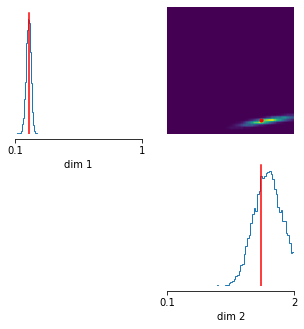

In [59]:
true_params = (0.2, 1.5)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 23049.70it/s]


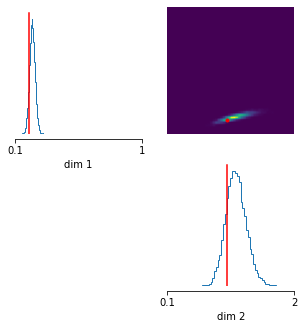

In [60]:
true_params = (0.2, 1.0)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 19692.24it/s]


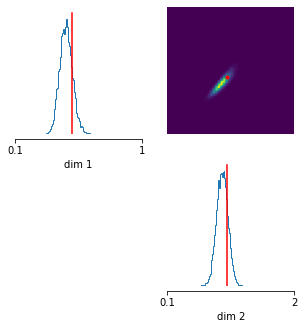

In [61]:
true_params = (0.5, 1.0)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Drawing 10000 posterior samples: 10038it [00:00, 46116.50it/s]                          


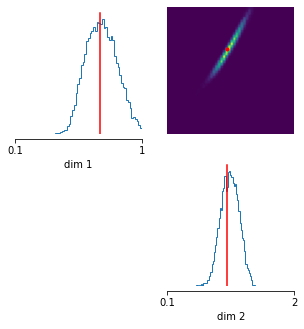

In [62]:
true_params = (0.7, 1.0)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Drawing 10000 posterior samples: 11238it [00:00, 35857.40it/s]                          


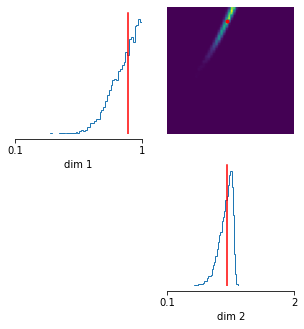

In [63]:
true_params = (0.9, 1.0)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Drawing 10000 posterior samples: 10035it [00:00, 19971.94it/s]                          


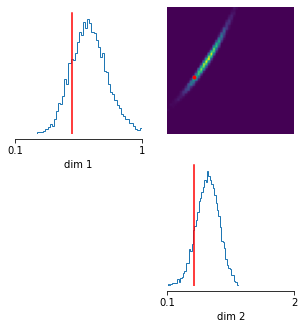

In [64]:
true_params = (0.5, 0.5)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 13329.41it/s]


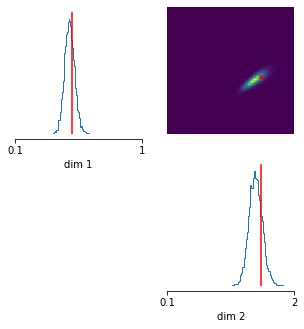

In [65]:
true_params = (0.5, 1.5)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 1000 simulations.:   0%|          | 1/1000 [00:00<04:01,  4.15it/s]

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:11<00:00, 14.03it/s]


 Neural network successfully converged after 26 epochs.

Drawing 1000 posterior samples: 1086it [00:00, 6576.72it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:48<00:00, 20.57it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 1000 posterior samples: 1155it [00:00, 5048.08it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 23.09it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 1000 posterior samples: 1296it [00:00, 1963.21it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [01:14<00:00, 13.41it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 1000 posterior samples: 1410it [00:00, 1831.13it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:49<00:00, 20.21it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 1000 posterior samples: 1220it [00:00, 4864.94it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:44<00:00, 22.50it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 1000 posterior samples: 1320it [00:00, 2794.28it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:42<00:00, 23.35it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 1000 posterior samples: 1172it [00:00, 5877.58it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:38<00:00, 25.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 1000 posterior samples: 1262it [00:00, 3955.81it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:39<00:00, 25.59it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 1000 posterior samples: 1158it [00:00, 5149.82it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:43<00:00, 23.14it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples: 11542it [00:01, 7921.01it/s]                          


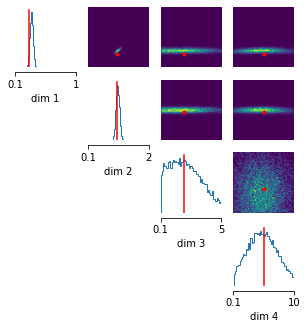

In [2]:
from spectralcomponents import DeltaEmissionLine


c1 = PowerLaw()
c2 = DeltaEmissionLine()
prior = BoxUniform(low=torch.tensor([0.1, 0.1, 0.1, 0.1]), 
                    high=torch.tensor([1, 2, 5, 10]))
spectrum = Spectrum(c1, c2)
def simulate_simple(params):
    simulator =  Simulator(spectrum, 1000, pileup='channels')
    data = simulator(params)
    return np.bincount(data[data>0], minlength=1024)

true_params = (0.3, 1, 2, 5)

simulator, prior = prepare_for_sbi(simulate_simple, prior)
x_0 = simulate_simple(true_params)

rounds = 10
num_sims = 1000

inference = SNPE(prior=prior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_0)
    proposal = posterior

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1,], [0.1, 2], [0.1, 5], [0.1, 10]],
    ticks=[[0.1, 1], [0.1, 2], [0.1, 5], [0.1, 10]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)


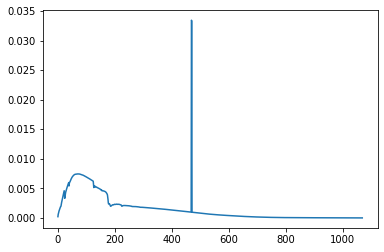

In [3]:
from matplotlib import pyplot as plt
plt.plot(spectrum.get_rate(true_params))

(array([182.,  28.,  59.,  56.,  50.,  50.,  36.,  43.,  32.,  35.,  27.,
         31.,  33.,  38.,  30.,  30.,  28.,  24.,  25.,   9.,  12.,  21.,
         15.,   8.,   6.,  11.,  11.,  12.,   9.,   8.,   5.,   6.,   9.,
          5.,   3.,   3.,   3.,   4.,   1.,   2.]),
 array([-1.0000e+00,  2.4550e+01,  5.0100e+01,  7.5650e+01,  1.0120e+02,
         1.2675e+02,  1.5230e+02,  1.7785e+02,  2.0340e+02,  2.2895e+02,
         2.5450e+02,  2.8005e+02,  3.0560e+02,  3.3115e+02,  3.5670e+02,
         3.8225e+02,  4.0780e+02,  4.3335e+02,  4.5890e+02,  4.8445e+02,
         5.1000e+02,  5.3555e+02,  5.6110e+02,  5.8665e+02,  6.1220e+02,
         6.3775e+02,  6.6330e+02,  6.8885e+02,  7.1440e+02,  7.3995e+02,
         7.6550e+02,  7.9105e+02,  8.1660e+02,  8.4215e+02,  8.6770e+02,
         8.9325e+02,  9.1880e+02,  9.4435e+02,  9.6990e+02,  9.9545e+02,
         1.0210e+03]),
 <BarContainer object of 40 artists>)

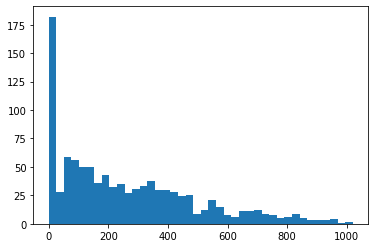

In [14]:
def simulate_simple(params):
    simulator =  Simulator(spectrum, 1000, pileup='channels')
    data = simulator(params)
    return data
plt.hist(simulate_simple((0.3, 1, 2, 5)), bins=40)

In [ ]:
x_0 = simulate_simple(true_params)
samples = posterior.sample((10000,), x=x_0)
lb, ub = np.percentile(samples[:, 0], [2.5, 97.5], axis=0)
if true_params[0] > lb[0] and true_params[0] < ub[0]:
    print('Power law: correct')
else:
    print('Power law: incorrect')
lb, ub = np.percentile(samples[:, 1], [2.5, 97.5], axis=0)
if true_params[1] > lb[0] and true_params[1] < ub[0]:
    print('Delta: correct')
else:
    print('Delta: incorrect')